In [1]:
# class Args():
#     def __init__(self):
#         self.output_dir = 'output-small'
#         self.model_type = 'gpt2'
#         self.model_name_or_path = 'microsoft/DialoGPT-small'
#         self.config_name = 'microsoft/DialoGPT-small'
#         self.tokenizer_name = 'microsoft/DialoGPT-small'
#         self.cache_dir = 'cached'
#         self.block_size = 512
#         self.do_train = True
#         self.do_eval = True
#         self.evaluate_during_training = False
#         self.per_gpu_train_batch_size = 4
#         self.per_gpu_eval_batch_size = 4
#         self.gradient_accumulation_steps = 1
#         self.learning_rate = 5e-5
#         self.weight_decay = 0.0
#         self.adam_epsilon = 1e-8
#         self.max_grad_norm = 1.0
#         self.num_train_epochs = 3
#         self.max_steps = -1
#         self.warmup_steps = 0
#         self.logging_steps = 1000
#         self.save_steps = 3500
#         self.save_total_limit = None
#         self.eval_all_checkpoints = False
#         self.no_cuda = False
#         self.overwrite_output_dir = True
#         self.overwrite_cache = True
#         self.should_continue = False
#         self.seed = 42
#         self.local_rank = -1
#         self.fp16 = False
#         self.fp16_opt_level = 'O1'

In [2]:
# import glob
# import logging
# import os
# import pickle
# import random
# import re
# import shutil
# from typing import Dict, List, Tuple

# import pandas as pd
# import numpy as np
# import torch

# from sklearn.model_selection import train_test_split

# from torch.nn.utils.rnn import pad_sequence
# from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
# from torch.utils.data.distributed import DistributedSampler
# from tqdm.notebook import tqdm, trange

# from pathlib import Path

# from transformers import (
#     MODEL_WITH_LM_HEAD_MAPPING,
#     WEIGHTS_NAME,
#     AdamW,
#     AutoConfig,
#     AutoModelWithLMHead,
#     AutoTokenizer,
#     PreTrainedModel,
#     PreTrainedTokenizer,
#     get_linear_schedule_with_warmup,
# )


# try:
#     from torch.utils.tensorboard import SummaryWriter
# except ImportError:
#     from tensorboardX import SummaryWriter

In [3]:
# tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
# model = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-medium")

In [4]:
# # Let's chat for 5 lines
# for step in range(5):
#     # encode the new user input, add the eos_token and return a tensor in Pytorch
#     new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

#     # append the new user input tokens to the chat history
#     bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

#     # generated a response while limiting the total chat history to 1000 tokens    
#     chat_history_ids = model.generate(
#     bot_input_ids, max_length=1000,
#     pad_token_id=tokenizer.eos_token_id
#     )

#     # pretty print last ouput tokens from bot
#     print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

In [5]:
from transformers import (
    AutoModelWithLMHead,
    AutoTokenizer,
    OpenAIGPTDoubleHeadsModel,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from IPython.display import clear_output
import sys
from tqdm import tqdm
import json

import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence

In [6]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-small")

/home/svasilyev/anaconda3/envs/venv/lib/python3.8/site-packages/transformers/modeling_auto.py:781: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [7]:
SPECIAL_TOKENS = {
    'bos_token': '<bos>', 
    'eos_token': '<eos>', 
    'pad_token': '<pad>',
#     'unk_token': '<unk>',
    'additional_special_tokens': ['<speaker1>', '<speaker2>']
}
tokenizer.add_special_tokens(SPECIAL_TOKENS)

5

In [8]:
model.resize_token_embeddings(len(tokenizer))

Embedding(50262, 768)

In [9]:
from itertools import chain

In [10]:
persona = [["i", "like", "playing", "football", "."],
           ["i", "am", "from", "NYC", "."]]
history = [["hello", "how", "are", "you", "?"],
           ["i", "am", "fine", "thanks", "."]]
reply = ["great", "to", "hear"]
bos, eos, speaker1, speaker2 = "<bos>", "<eos>", "<speaker1>", "<speaker2>"

In [11]:
def build_inputs(persona, history, reply):
    # Build our sequence by adding delimiters and concatenating
    sequence = [[bos] + list(chain(*persona))] + history + [reply + [eos]]
    sequence = [sequence[0]] + [ [speaker2 if (len(sequence)-i) % 2 else speaker1] + s
                                for i, s in enumerate(sequence[1:])]
    # Build our word, segments and position inputs from the sequence
    words = list(chain(*sequence))                          # word tokens
    segments = [speaker2 if i % 2 else speaker1             # segment tokens
                for i, s in enumerate(sequence) for _ in s]
    position = list(range(len(words)))                      # position tokens
    return words, segments, position, sequence

In [12]:
words, segments, position, sequence = build_inputs(persona, history, reply)

In [13]:
lm_targets = ([-100] * sum(len(s) for s in sequence[:-1])) \
             + [-100] + tokenizer.convert_tokens_to_ids(sequence[-1][1:])
last_token = len(words) - 1
padding_length = len(words)
def pad(x, padding):
    return x + [padding] * (padding_length - len(x))

(words, segments) = [pad(tokenizer.convert_tokens_to_ids(x), '<pad>')
                                   for x in (words, segments)]
lm_targets = pad(lm_targets, -1)
input_ids = torch.tensor([words], dtype=torch.long)
token_type_ids = torch.tensor([segments], dtype=torch.long)
lm_labels = torch.tensor([lm_targets], dtype=torch.long)


In [14]:
lm_loss = model(input_ids, labels=lm_labels, token_type_ids=token_type_ids)

In [15]:
with open('personachat.json') as f:
    data = json.load(f)
print(len(data))
train_data = data[:500]
eval_data = data[500:750]

10904


In [16]:
class PersonaChatDatasetJSON(Dataset):
    def __init__(self, data, tokenizer, context_len):
        self.examples = []
        speaker1_token_id = tokenizer.encode('<speaker1>')
        speaker2_token_id = tokenizer.encode('<speaker2>')
        if isinstance(data, str):
            with open(data) as f:
                self.examples = json.load(f)
        else:
            self.examples = []
            for dialog in tqdm(data):
                if len(dialog[2]) < context_len + 1:
                    continue
                persona1 = []
                for e in dialog[0]:
                    persona1 += tokenizer.encode(e)
                persona2 = []
                for e in dialog[1]:
                    persona2 += tokenizer.encode(e)

                for i in range(context_len, len(dialog[2])):
                    input_ids = [tokenizer.bos_token_id]
                    input_ids += persona1 if i % 2 == 0 else persona2
                    for k, j in enumerate(range(i - context_len, i+1)):
                        input_ids += speaker1_token_id if k % 2 == 0 else speaker2_token_id
                        input_ids += tokenizer.encode(dialog[2][j])
                    input_ids += [tokenizer.eos_token_id]
                    labels = [-100] * len(input_ids)
                    for j in range(len(input_ids)-len(tokenizer.encode(dialog[2][i]))-1, len(input_ids)):
                        labels[j] = input_ids[j]
                    segments = [0] * len(input_ids)
                    k = 0
                    for j in range(len(input_ids)):
                        if input_ids[j] == speaker1_token_id[0] or input_ids[j] == speaker2_token_id[0]:
                            k += 1
                        segments[j] = k % 2
                    self.examples.append((input_ids, labels, segments))
                    
    def save(self, filename):
        with open(filename, 'w') as f:
            json.dump(self.examples, f)
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, item):
        return torch.transpose(torch.tensor(self.examples[item], dtype=torch.long), 0, 1)

In [17]:
def collate(examples):
#     print(examples)
    if tokenizer._pad_token is None:
        return pad_sequence(examples, batch_first=True)
    return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

In [18]:
train_dataset = PersonaChatDatasetJSON(train_data, tokenizer, 1)
train_dataset.save('preproc_PC_train_01.json')

100%|██████████| 500/500 [00:02<00:00, 174.16it/s]


In [19]:
eval_dataset = PersonaChatDatasetJSON(eval_data, tokenizer, 0)
eval_dataset.save('preproc_PC_eval_01.json')

100%|██████████| 250/250 [00:01<00:00, 229.08it/s]


In [20]:
train_dataset = PersonaChatDatasetJSON('preproc_PC_train_01.json', tokenizer, 0)
train_sampler = RandomSampler(train_dataset) 
train_dataloader = DataLoader(
    train_dataset, sampler=train_sampler,
    batch_size=1, collate_fn=collate
)

In [21]:
eval_dataset = PersonaChatDatasetJSON('preproc_PC_eval_01.json', tokenizer, 0)
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(
    eval_dataset, sampler=eval_sampler,
    batch_size=1, collate_fn=collate
)

In [22]:
for batch in train_dataset:
    print(batch)
    break

tensor([[50257,  -100,     0],
        [   72,  -100,     0],
        [  588,  -100,     0],
        [  460,  -100,     0],
        [  768,  -100,     0],
        [  290,  -100,     0],
        [  348,  -100,     0],
        [  715,  -100,     0],
        [ 1359,  -100,     0],
        [   13,  -100,     0],
        [ 1462,  -100,     0],
        [ 2652,  -100,     0],
        [  287,  -100,     0],
        [ 5485,  -100,     0],
        [  837,  -100,     0],
        [ 1312,  -100,     0],
        [15505,  -100,     0],
        [ 1125,  -100,     0],
        [  316,  -100,     0],
        [39095,  -100,     0],
        [  379,  -100,     0],
        [  262,  -100,     0],
        [26626,  -100,     0],
        [   13,  -100,     0],
        [  259,  -100,     0],
        [ 1029,  -100,     0],
        [ 1524,  -100,     0],
        [  837,  -100,     0],
        [ 1312,  -100,     0],
        [ 1625,  -100,     0],
        [  287,  -100,     0],
        [  718,  -100,     0],
        

In [23]:
BATCH_SIZE = 1
WEIGHT_DECAY = 0.0
LEARNING_RATE = 5e-5
ADAM_EPSILON = 1e-8
WARMUP_STEPS = 0
EPOCH_NUM = 2
DEVICE = 'cuda'

In [24]:
def train(model, tokenizer, train_dataset, eval_dataset):
    model.to(DEVICE)
    
    train_sampler = RandomSampler(train_dataset) 
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler,
        batch_size=BATCH_SIZE, collate_fn=collate
    )
    
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler,
        batch_size=BATCH_SIZE, collate_fn=collate
    )
    
    model.resize_token_embeddings(len(tokenizer))
    
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": WEIGHT_DECAY,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, eps=ADAM_EPSILON)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=len(train_dataset) * EPOCH_NUM
    )
    
    train_losses_epochs = []
    eval_losses_epochs = []
    for epoch in range(EPOCH_NUM):
        model.train()
        train_losses = []
        for batch in tqdm(train_dataloader):
            inputs, labels, types = batch[:, :, 0], batch[:, :, 1], batch[:, :, 2]
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            types = types.to(DEVICE)
#             model.train()
            outputs = model(inputs, labels=labels, token_type_ids=types)
            loss = outputs[0]

            model.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_losses.append(loss.item())
        
        model.eval()
        eval_losses = []
        for batch in eval_dataloader:
            inputs, labels, types = batch[:, :, 0], batch[:, :, 1], batch[:, :, 2]
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            types = types.to(DEVICE)
            
            with torch.no_grad():
                outputs = model(inputs, labels=labels, token_type_ids=types)
            eval_losses = outputs[0].item()
            
        train_losses_epochs.append(np.mean(train_losses))
        eval_losses_epochs.append(np.mean(eval_losses))
            
        clear_output(True)          
        sys.stdout.write('\rEpoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}, Perplexity: {3:.3f}/{4:.3f}'.format(
                    epoch, train_losses_epochs[-1], eval_losses_epochs[-1], np.exp(train_losses_epochs[-1]), np.exp(eval_losses_epochs[-1])))
        if epoch > 0:
            plt.figure(figsize=(12, 5))
            plt.plot(train_losses_epochs[0:], label='Train')
            plt.plot(eval_losses_epochs[0:], label='Valid')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.show()

Epoch 1... (Train/Test) Loss: 3.094/3.867, Perplexity: 22.067/47.807

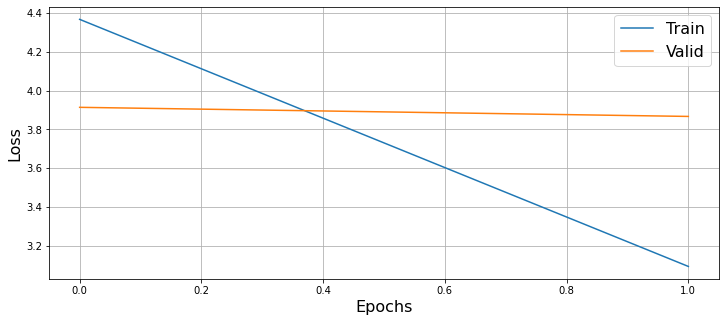

In [25]:
train(model, tokenizer, train_dataset, eval_dataset)

In [26]:
model.save_pretrained('personachat_model')
tokenizer.save_pretrained('personachat_model')

('personachat_model/vocab.json',
 'personachat_model/merges.txt',
 'personachat_model/special_tokens_map.json',
 'personachat_model/added_tokens.json')

In [27]:
model = AutoModelWithLMHead.from_pretrained('personachat_model').to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained('personachat_model')

In [28]:
def get_response(model, tokenizer, context, persona):
    speaker1_token_id = tokenizer.encode('<speaker1>')
    speaker2_token_id = tokenizer.encode('<speaker2>')
    
    persona_code = []
    for e in persona:
        persona_code += tokenizer.encode(e)

    input_ids = [tokenizer.bos_token_id]
    input_ids += persona_code
    for i in range(len(context)):
        input_ids += speaker1_token_id if i % 2 == 0 else speaker2_token_id
        input_ids += tokenizer.encode(context[i])
    input_ids += [tokenizer.eos_token_id]
    segments = [0] * len(input_ids)
    k = 0
    for i in range(len(input_ids)):
        if input_ids[i] == speaker1_token_id[0] or input_ids[i] == speaker2_token_id[0]:
            k += 1
        segments[i] = k % 2
    
    inputs = torch.tensor(input_ids, device=DEVICE).view(1, -1)
    types = torch.tensor(segments, device=DEVICE).view(1, -1)
    
    response = model.generate(
        inputs, max_length=200,
        pad_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=3,
        do_sample=True,
        top_k=100,
        top_p=0.7,
        temperature=0.8,
        token_type_ids=types
    )
    return tokenizer.decode(response[0,:], skip_special_tokens=True)

In [29]:
tokenizer.encode('My name is John.')

[3666, 1438, 318, 1757, 13]

In [30]:
persona = [
    'My name is John.',
    'I am living in Hew York.'
]
context = [
    'Hi, how are you?',
    'I am great. Where are you from?'
]

In [31]:
get_response(model, tokenizer, context, persona)

'My name is John.I am living in Hew York.Hi, how are you?I am great. Where are you from?i am from the us. where are you?i have never been to japan.i like to go there.nice. i have never left the us!i live in the us too.oh ok. how about you?i am in california.you?hi. i am from japan, how about yourself?great. i like to travel.great! where are u from?sounds nice..where are you going?the beach?gonna?wonderful. you? i am in the beach? i work?y?very good.. you. you like you??you... just done?..???. you!..!. you just dancing?? you'